In [24]:
from __future__ import print_function
import time
import h5py as h5
import numpy as np
#import numba
import sklearn
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

print ("Numpy      ver. ", np.__version__)
#print ("Numba      ver. ", numba.__version__)  ##  optimize numpy?!?
print ("H5Py       ver. ", h5.__version__)
print ("SKLearn    ver. ", sklearn.__version__)
print ("TensorFlow ver. ", tf.__version__)


import matplotlib
#matplotlib.use('agg')             ## Need for CMD
import matplotlib.pyplot as plt
%matplotlib inline


Numpy      ver.  1.14.5
H5Py       ver.  2.7.1
SKLearn    ver.  0.19.2
TensorFlow ver.  1.10.1


In [25]:
H5_FILE="./white_h_4096_dm2.h5"
H5_FILE="./white_h_8192_dm2.h5"
H5_FILE="./white_h_8192_dm1.h5"
#!wget http://grqc.ncts.ncku.edu.tw/~lincy/GWDA/white_h_8192_dm2.h5
#!ls /tmp/tf_tmp -al

# Load data
import GWDA.loader
GWdata = GWDA.loader.GWInject(H5_FILE)
RATE   = GWdata.srate
print("Sampling rate : ", RATE)

#import GWDA.loader
#GWDA.loader.plot_template(H5_FILE)

Sampling rate :  8192


In [26]:
###
###  Construct TF graph
###
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

tf.reset_default_graph()
DIM   = RATE
LRATE = 1e-5   ##-4
keep_prob = tf.placeholder(tf.float32)   ##  for dropout, not used.
lrate     = tf.placeholder(tf.float32)
#bs        = tf.placeholder(tf.int64)     ##  use dynamics batch_size to account for train/test stage both

x = tf.placeholder(tf.float32, [None,DIM])
y = tf.placeholder(tf.float32, [None,1])

import GWDA.model
logits = GWDA.model.CNN_3(x, keep_prob, DIM)
#logits = GWDA.model.CNN_3(x, keep_prob, DIM)

# Compute predictions
#with tf.name_scope('eval'):
predict_prob = tf.sigmoid(logits, name="sigmoid_tensor")
predict_op   = tf.cast( tf.round(predict_prob), tf.int32 )
#with tf.name_scope('loss'):
## with reduction compared to tf.nn.softmax_cross_entropy_with_logits_v2 
loss_op = tf.losses.sigmoid_cross_entropy(logits=logits, multi_class_labels=y)
with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(LRATE).minimize(loss_op)
    #optimizer = tf.train.AdadeltaOptimizer(LRATE, rho=0.90, epsilon=1e-08).minimize(loss_op)
    #optimizer = tf.train.GradientDescentOptimizer(LRATE).minimize(loss_op)

#correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
#correct_prediction = tf.cast(correct_prediction, tf.float32)
#accuracy = tf.reduce_mean(correct_prediction)
_, accuracy    = tf.metrics.accuracy(labels=y, predictions=predict_op  )
#_, sensitivity = tf.metrics.sensitivity_at_specificity(labels=y, predictions=predict_op, specificity=0.005 )
_, sensitivity = tf.metrics.recall(labels=y, predictions=predict_op)

_, fp = tf.metrics.false_positives(labels=y, predictions=predict_op  )
_, fn = tf.metrics.false_negatives(labels=y, predictions=predict_op  )
_, tp = tf.metrics.true_positives(labels=y, predictions=predict_op  )
_, tn = tf.metrics.true_negatives(labels=y, predictions=predict_op  )

#tf.summary.histogram('loss', loss_op)
#tf.summary.scalar('loss', loss_op)
#tf.summary.scalar('accuracy', accuracy)



In [27]:
def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope("summaries_%s"% var.name.replace("/", "_").replace(":", "_")):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

    
### check all vari\ables
#tf.global_variables_initializer()
if 1:
    vars = 0
    for v in tf.global_variables():
        #print (v)
        vars += np.prod(v.get_shape().as_list())
    print("Whole size: %.3f MB | Var # : %d" % (8*vars/(1024**2), len(tf.global_variables()) ) )

    vars = 0
    for v in tf.trainable_variables():
        #print (v)
        #variable_summaries(v)
        vars += np.prod(v.get_shape().as_list())
    print("Model size: %.3f MB | Var # : %d" % (8*vars/(1024**2), len(tf.trainable_variables()) ) )

    vars = 0
    for v in tf.local_variables():
        #print (v)
        vars += np.prod(v.get_shape().as_list())
    print("Local var size: %.3f Bytes | Var # : %d" % (8*vars, len(tf.local_variables()) ) )

Whole size: 12.199 MB | Var # : 32
Model size: 4.000 MB | Var # : 10
Local var size: 64.000 Bytes | Var # : 8


In [28]:
BATCH = 128
EPOCHS = 5000
MONITOR = 10

PATIENCE = 4
TOLLERENCE = 1.e-8
##TOLLERENCE = 1.e-5

In [29]:
##
##  Training with fixed template ....
##

#ROOT_FOLDER = './model'
ROOT_FOLDER = '/tmp/tf_tmp'

#TEST_LIST = [1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
TRAIN_A =   [2.0,1.6,1.4, 1.2, 1.1, 1.0, 0.9, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5]
#TEST_LIST = [1.5, 1.4, 1.3, 1.2,1.1,1.0,0.9,0.8,0.7]
#TRAIN_A =   [1.4,1.2,1.0,0.8]

TRAIN_A =   [1.8, 1.6, 1.4, 1.3, 1.2, 1.1, 1.0, 0.8]

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())   ### init w, bias to gaussian noise
    merged = tf.summary.merge_all()   ## call merged to do every summary
    saver = tf.train.Saver(max_to_keep=50)

    #load_path = saver.restore(sess, "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, 1.0 ) )
    
    fig0 = plt.figure() ## plt loss 
    
    for amp in TRAIN_A:
        ## summarize to a new folder
        train_writer = tf.summary.FileWriter("%s/train_%4.2f" % (ROOT_FOLDER, amp ) )
        #train_writer.add_graph(tf.get_default_graph())
        #print('Saving graph to: %s' % ROOT_FOLDER)
    
        sess.run(tf.local_variables_initializer())  ###  only local vars like TP, TN, FP, FN to be init

        time0 = time.time()
        X0, Y0 = GWdata.get_train_set(A=amp, nc=2)
        X1, Y1 = GWdata.get_val_set(A=amp, nc=2)
        X = np.vstack( (X0,X1) ) 
        Y = np.vstack( (Y0,Y1) ) 
        
        print('=== get_train_setc ===   Reading time in sec :',  time.time()-time0 )

        print("Trainning for A= %f , dataset size: %d"% (amp, len(X) ))

        patience = 0
        time0 = time.time()
        
        loss_in_epoches = []
        for e in range(EPOCHS):
            Xt, Xv, Yt, Yv = train_test_split(X, Y, test_size=0.25, shuffle=True, random_state=None)
            #Xt, _, Yt, _ = train_test_split(X, Y, test_size=0.01, shuffle=True, random_state=None)
            if (e%20==19):
                LRATE = LRATE*0.9
            
            STEPS   = int(len(Xt) / BATCH) 
            for i in range(STEPS):
                xbatch = Xt[i*BATCH:(i+1)*BATCH, :]
                ybatch = Yt[i*BATCH:(i+1)*BATCH, :]

                #_, loss = sess.run( [optimizer, loss_op], feed_dict={ x:xbatch, y:ybatch }   ) 
                #if (i%10==0): print('    Loss: %f', loss) 
                _ = sess.run( [optimizer], feed_dict={ x:xbatch, y:ybatch, lrate:LRATE }   ) 

                #_, summary = sess.run( [optimizer, merged], feed_dict={ x:xbatch, y:ybatch }   ) 
                #train_writer.add_summary(summary, global_step=e)

            ### evaluate    
            loss, acc, sen = sess.run( [loss_op, accuracy, sensitivity],   feed_dict={x:Xv, y:Yv} )
            loss_in_epoches.append(loss)

            if e % MONITOR == 0:
                duration = time.time() - time0
                speed = STEPS * BATCH * (e+1) / duration
                print('  Epoch: %3d, loss: %10.3e acc: %4.2g sen: %4.2f sec: %5.1f speed: %7.1f wf/sec' 
                      % (e, loss, acc, sen, duration, speed) )
            if loss < TOLLERENCE:
                if patience > PATIENCE: break
                patience += 1
            else:
                patience = 0
        
        
        save_path = saver.save(sess, "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, amp ) )
        print("Model saved at %s" % save_path)
        
        ### plot in each epoch
        plt.semilogy(loss_in_epoches, lw=1, label="A=%s"%amp)
        
    plt.legend()
    #fig0.show()
    fig0.savefig("loss.png")

=== get_train_setc ===   Reading time in sec : 8.35842108727
Trainning for A= 1.800000 , dataset size: 15309
  Epoch:   0, loss:  4.089e-01 acc: 0.86 sen: 0.63 sec:   6.3 speed:  1808.7 wf/sec


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [16]:
####
####  Just for testing
####

NUM_AUC=200000
thres=[10**(-i)-(1e-11) for i in range(10,-1,-1)]
print(thres)
_, fna = tf.metrics.false_negatives_at_thresholds(labels=y, predictions=predict_prob,thresholds=thres)
_, fpa = tf.metrics.false_positives_at_thresholds(labels=y, predictions=predict_prob,thresholds=thres)
_, tna = tf.metrics.true_negatives_at_thresholds(labels=y, predictions=predict_prob,thresholds=thres)
_, tpa = tf.metrics.true_positives_at_thresholds(labels=y, predictions=predict_prob,thresholds=thres)
print (fna)
    

[9e-11, 9.9e-10, 9.99e-09, 9.999e-08, 9.999899999999999e-07, 9.99999e-06, 9.999999e-05, 0.00099999999, 0.00999999999, 0.09999999999, 0.99999999999]
Tensor("false_negatives_1/AssignAdd:0", shape=(11,), dtype=float32_ref)


INFO:tensorflow:Restoring parameters from ./model/model_1.80.ckpt
Test for A= 1.90 : Acc:     0.997, Sen:     1.000, TP/TN/FP/FN:   648   642     4     0 
Test for A= 1.50 : Acc:     0.991, Sen:     1.000, TP/TN/FP/FN:   648   635    11     0 
Test for A= 1.40 : Acc:     0.995, Sen:     0.998, TP/TN/FP/FN:   646   641     6     1 
Test for A= 1.30 : Acc:     0.972, Sen:     0.963, TP/TN/FP/FN:   623   635    12    24 
Test for A= 1.20 : Acc:     0.906, Sen:     0.820, TP/TN/FP/FN:   529   643     6   116 
Test for A= 1.10 : Acc:     0.783, Sen:     0.576, TP/TN/FP/FN:   373   640     6   275 
Test for A= 1.00 : Acc:     0.670, Sen:     0.346, TP/TN/FP/FN:   224   643     4   423 
Test for A= 0.90 : Acc:     0.572, Sen:     0.154, TP/TN/FP/FN:   100   640     5   549 
Test for A= 0.80 : Acc:     0.526, Sen:     0.066, TP/TN/FP/FN:    43   637     9   605 
Test for A= 0.70 : Acc:     0.512, Sen:     0.034, TP/TN/FP/FN:    22   640     7   625 
Test for A= 0.50 : Acc:     0.504, Sen:     

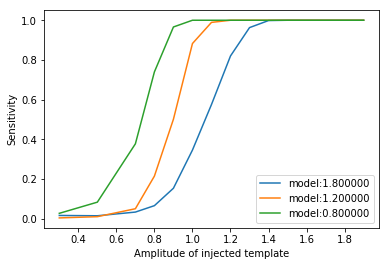

In [164]:
###
###  Testing...
###
BATCH = 4096
ROOT_FOLDER = './model'

TRAIN_A = [1.0]
TRAIN_A =   [1.8, 1.2, 0.8]
TEST_LIST = [1.9, 1.5, 1.4, 1.3, 1.2,1.1,1.0,0.9,0.8,0.7,0.5,0.3]


with tf.Session() as sess:
    
    test_writer  = tf.summary.FileWriter(ROOT_FOLDER + '/test')
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(max_to_keep=50)

    plt.figure()
    for m in TRAIN_A:
        #try:
        load_path = saver.restore(sess, "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, m ) )
        #except: 
        ##    continue

        gacc=[]
        gsen=[]

        
        for amp in TEST_LIST:
            sess.run(tf.local_variables_initializer())
            
            X, Y  = GWdata.get_shifted_test_set(A=amp)
            Xts, _, Yts, _ = train_test_split(X, Y, test_size=0.01, shuffle=True, random_state=None)
            i=int(np.random.random()* int(len(Xts)/BATCH) )
            xbatch = Xts[i*BATCH:(i+1)*BATCH, :]
            ybatch = Yts[i*BATCH:(i+1)*BATCH, :]
            #Xts, Yts   = GWdata.get_shifted_test_set(A=amp, shift=2000)  

            acc, sen, ttp, ttn, tfp, tfn = sess.run([accuracy, sensitivity, tp, tn, fp, fn ], 
                                                          feed_dict={ x: xbatch, y: ybatch })
            gsen.append(sen)
            gacc.append(acc)
            print("Test for A= %4.2f : Acc: %9.3f, Sen: %9.3f, TP/TN/FP/FN: %5d %5d %5d %5d " 
                  % (amp, acc, sen, ttp, ttn, tfp, tfn) )

        plt.plot(TEST_LIST, gsen, label="model:%f"%m)
    
    plt.xlabel("Amplitude of injected template")
    plt.ylabel("Sensitivity")
    plt.legend()
    #plt.show()
    plt.savefig("infer.png")


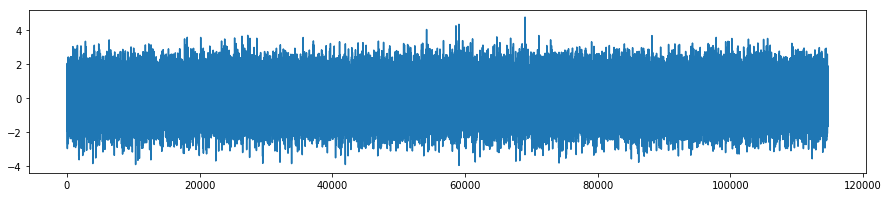

INFO:tensorflow:Restoring parameters from ./model/model_0.80.ckpt


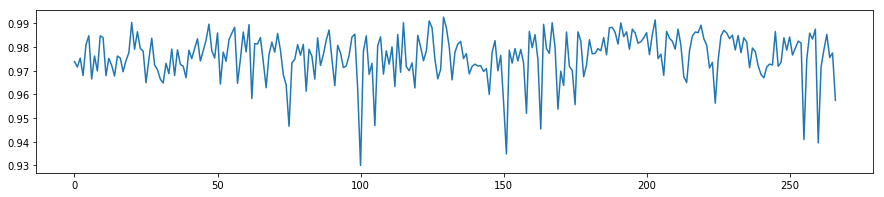

In [16]:
###
###  Testing real data...
###
wopt = {"figsize": (15,3) }

ROOT_FOLDER = './model'
TRAIN_A = [0.8]


SKIP = RATE  ##4*RATE   ## to remove the FFT gibbs effect
data = np.load("real8k/GW150914_H1_w.npy")[SKIP:-SKIP]
plt.figure(**wopt)
plt.plot(data)
plt.show()

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(max_to_keep=50)

    load_path = saver.restore(sess, "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, TRAIN_A[-1] ) )
    sess.run(tf.local_variables_initializer())

    ## predict batch-by-batch    
    DS  = 400    ## every ~200 ms
    dsn = 1 + int( (len(data)-RATE) / DS )    ## of prediction point
    MB  = 256
    prob = np.zeros(dsn)
    for i in range(0, dsn, MB):   ###range(int(np.ceil(dsn/MB))):    # for each MB "mini-batch"

        batch  = min(i+MB, dsn) - i                 ### take care the tail
        xbatch = np.zeros([batch, RATE])
        for b in range(batch):
            s = int((b+i)*DS)
            xbatch[b,:] = data[s:s+RATE]
        [p_] = sess.run([predict_prob], feed_dict={ x: xbatch })
        prob[i: i + batch] = p_.flatten()
    
        
plt.figure(**wopt)
plt.plot(prob.flatten())


8192 0


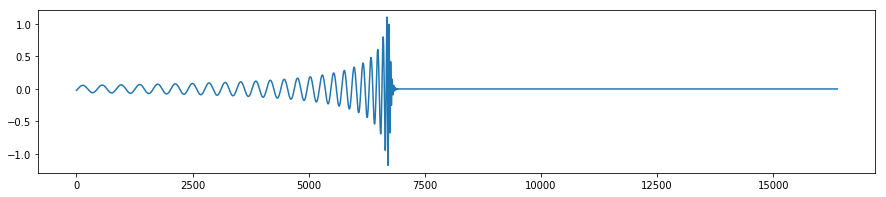

INFO:tensorflow:Restoring parameters from ./model/model_0.80.ckpt


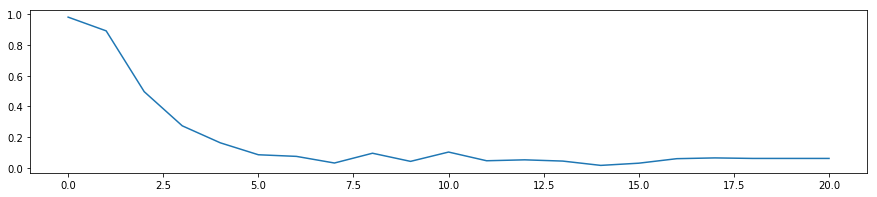

In [15]:
###
###  Testing fake data...
###
ROOT_FOLDER = './model'

TRAIN_A = [0.8]

def gen():
    
    tmp = GWInject(H5_FILE)
    inj = tmp.f['train_hp'][10]

    data = np.random.normal(0,0.0,RATE*2)
    data[:RATE] += inj 
    return data

data = gen()
plt.figure(**wopt)
plt.plot(data)
plt.show()

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(max_to_keep=50)

    load_path = saver.restore(sess, "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, TRAIN_A[-1] ) )
    sess.run(tf.local_variables_initializer())

    ## predict batch-by-batch    
    DS  = 400    ## every ~200 ms
    dsn = 1 + int( (len(data)-RATE) / DS )    ## of prediction point
    MB  = 256
    prob = np.zeros(dsn)
    for i in range(0, dsn, MB):   ###range(int(np.ceil(dsn/MB))):    # for each MB "mini-batch"

        batch  = min(i+MB, dsn) - i                 ### take care the tail
        xbatch = np.zeros([batch, RATE])
        for b in range(batch):
            s = int((b+i)*DS)
            xbatch[b,:] = data[s:s+RATE]
        [p_] = sess.run([predict_prob], feed_dict={ x: xbatch })
        prob[i: i + batch] = p_.flatten()
    
        
plt.figure(**wopt)
plt.plot(prob.flatten())



8192 0


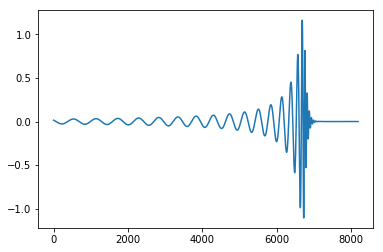